# First Pipeline

## Introduction


In this assignment, I am going to explore how much money I spend on food. 
Each month, bank of america sends my bank statement, but I never really look at it. At the same time, each month, I am always wondering what I spent my money on. From what I remember, I usually spend most of my money on food, but it is hard to actually keep track of it. So in this assignment, I wil use those bank statements to make a model that classifies each transaction as spent on food or non-food items from the description of the transaction.


## 1, 2. Data exploration


I spent this summer in the US, where cost of food was especially expensive. For consistency, I chose to use data from these months I spend in the US because other countries transactions are hard to understand and includes many non-english words, that even I cannot comprehend. I downloaded data from 05/15/2023 - 09/11/2023 transactions that was deducted from my account as a csv file, which has 159 entries. The dataset has 4 columns about transactions: date, description, amount. I also added 4th column that indicates whether the money spend on food or not with 1(food) or 0(non-food) (I did this manually, it was easy for me to classify since the description gave off where I spent it. For example: Mcdonalds, Target, etc.). All the descriptions are written in english by the bank of america. 

For some transactions that are titled as Target or CVS, realistically, I could buy any item from these stores. But I noted them as 1 (food) because usually I go into these stores with an intent to buy food, even though there could be one or two non-food items in there. 

In [1]:
#importing useful libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import re
from sklearn.model_selection import StratifiedKFold
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import LeaveOneOut
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

# Load dataset
data = pd.read_csv('/Users/tergel.s/Downloads/bank.csv')
data.head()

,Date,Description,Amount,Food or not?
0,05/15/2023,Zelle Transfer Conf# o0sucyi1m; TSENGUUN GANTU...,-66.00,0
1,05/16/2023,WHOLEFDS STV # 05/15 MOBILE PURCHASE CHICAGO IL,-4.85,1
2,05/17/2023,UAS DES:EPAYMENT ID: 1O3S86T7BI INDN:TERGEL SU...,-55.96,0
3,05/18/2023,TARGET 00032078 05/15 MOBILE PURCHASE CHICAGO IL,-4.07,1
4,05/19/2023,TARGET 00032078 05/17 MOBILE PURCHASE CHICAGO IL,-24.28,1


## 3. Cleaning


The third section of the notebook**** should include a markdown section explaining any necessary cleaning, pre-processing, and feature engineering the data requires, and a include a code block completing these steps. You may also wish to perform some basic exploratory data analysis at this point reporting and visualizing some samples and appropriate descriptive statistics.

The amount of money I spend is very random. For example, on one day, I will spend a twenty dollar on food and take a bus, or I take a lyft and refuse to waste money on food. Even for bigger transactions, it is random since I could spend hundreds of dollars on food during a trip, or just spend the same amount of money on taxes, rent, etc.
In the vizualiation below, we can see that the spend for food and non-food items almost the same. Therefore, I will exclude the amount column from training, and only focus on the text classification of the transactions descriptions. 

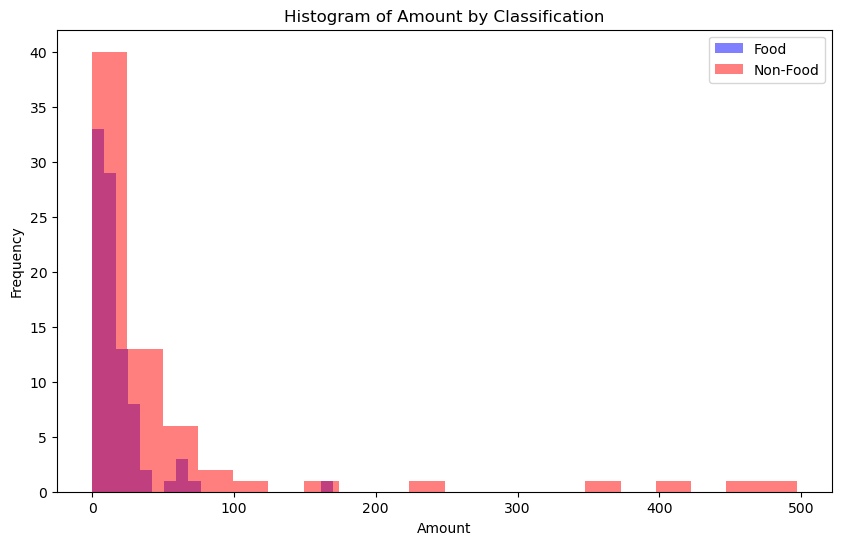

In [2]:
# Separate the data into two subsets based on the "Food or not?" column
food_data = data[data['Food or not?'] == 1]
non_food_data = data[data['Food or not?'] == 0]

# Set up the plot
# Make the values positive to describe how much is spent
plt.figure(figsize=(10, 6))
plt.hist(-food_data['Amount'], bins=20, alpha=0.5, label='Food', color='blue')
plt.hist(-non_food_data['Amount'], bins=20, alpha=0.5, label='Non-Food', color='red')

# Add labels and legend
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.title('Histogram of Amount by Classification')
plt.legend()

# Show the plot
plt.show()


Since I do some type of transaction every day and the date column does not indicate anything about it being food or not, so the date column in the dataset is not relevant in the classification. It also means that we need to remove dates from the transaction description since some looks like: "LYFT RIDE MON 7PM 06/26 PURCHASE 855-865-9553 CA"
 
In the "description" column, we also want to make sure that we do not confuse the model with capital or small letters, so we will convert all the words in the descriptioin to small letters to make it case-insensitive.

Plus, we can notice that many of the descriptions have words indicating which state I was in when I bought the item. This does not indicate anything about if I bought food or not. So we will also delete these words from the descriptions. 

In [3]:
# Define the date pattern (MM/DD or MM/DD/YY format)
date_pattern = r'\d{1,2}/\d{1,2}(/20\d{2})?'

# Function to remove dates from "description"
def remove_dates(description):
    return re.sub(date_pattern, '', description)

# Apply the function to the "description" column
data['Description'] = data['Description'].apply(remove_dates)

#making case-insensitive by making everyhting small
data['Description'] = data['Description'].str.lower()

# Define the list of keywords to be removed
keywords_to_remove = ["austin", "texas", "dallas", "il", "chicago", "tx"]

# Loop through the keywords and remove them from the "description" column
for keyword in keywords_to_remove:
    data['Description'] = data['Description'].str.replace(r'\b' + keyword + r'\b', '', regex=True, case=False)


# Split the data into X and y
X = data['Description']  # Description as input feature
y = data['Food or not?']  # Food or not food as the target variable

X.head()


0    zelle transfer conf# o0sucyi1m; tsenguun gantu...
1                    wholefds stv #  mobile purchase  
2    uas des:epayment id: 1o3s86t7bi indn:tergel su...
3                   target 00032078  mobile purchase  
4                   target 00032078  mobile purchase  
Name: Description, dtype: object

## 4. Task
In this assignment, I am gonna perform a binary classification of True or False (1 or 0) on each transaction to determine whether the spend was on food or non food items.  
Now, we will split the dataset into 3 sets: test set, train set, and validation set. Using the train set, we will train the model to learn the patterns in the data, while test set it for us to see how well the model learned. The validation set is for model selection and tuning hyperparameters. In this case, we will assign 70% of the dataset to the test set, 15% to training set, and 15% to validation set. This is important because we need most of the data to train the model as accurately as possible, at the same time, we need to make sure the test and validation are reasonably-sized to give us useful information on the performance of the model and model selection. 

For model selection, we will use the validation set to evaluate model's performance, after training it on the training set. This helps to choose the best-performing model. 
Test set will be not used until we are done with training the model to how well the model will perform on unseen data.

In [4]:
# Split the dataset into training and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42) #'random_state' ensures reproducibility.
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

## 5. Model selection

Before we commit to a model, let's run a quick trial on which model does better in this problem out of some models that can work with binary classfication: Multinomial Naive Bayes, Logistic Regression, Support Vector Machine (see below). 

We can see that Logistic Regression and Support Vector Machine Models have the same accuracies, which are better than the Multinomial Naive bayes. 

For this problem, we will use Logistic regression. For a small dataset like this one, Logistic Regression is less prone to overfitting and easy to interpret the results. It is commonly used for solving classificaiton problems. It uses a logistic (sigmoid function, which can take values between 0 and 1) funciton to identify the relationship between the variables. As a result, it outputs probabilities on which class the item belongs. 
On the other hand, SVM creates a hyperplane to separate the classes and is able to learn patterns from complex datasets. It is a complex model capable model for both classification and regression, and can work with unstructured data. However, we choose linear regression since this dataset is simple, and once the algorithm figures out specific words indicating about food, it can easily classify the transactions. 

In [5]:
# Vectorize text data
vectorizer = CountVectorizer(stop_words='english')
X_train_vect = vectorizer.fit_transform(X_train)
X_val_vect = vectorizer.transform(X_val)

# Initialize models
models = {
    'Multinomial Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(),
    'Support Vector Machine': SVC()
}

# Evaluate models
for name, model in models.items():
    model.fit(X_train_vect, y_train)
    predictions = model.predict(X_val_vect)
    accuracy = accuracy_score(y_val, predictions)
    print(f'Model: {name}, Accuracy: {accuracy:.4f}')


Model: Multinomial Naive Bayes, Accuracy: 0.8333
Model: Logistic Regression, Accuracy: 0.8750
Model: Support Vector Machine, Accuracy: 0.8750


At the heart of the logistic regression, there is a linear regression with equation with given a set of features X1, X2, …Xn:
z = β0 + β1X1 + β2X2 + … + βnXn
where β are weights for respective featurues, and β0 as bias. 

With linear regression equation, we could get any values, but we need a probability. That is why we use sigmoid fucntion that takes values between 0 and 1. The sigmoid function is expressed by P(z)= 1/(1+e^(-z)). 

To evaluate how the model performs we use Binary Cross Entropy, which takes also values between 0 and 1. When a model predicts well, it should be closer to 0. The equation for Binary Cross Entropy of one data point is:

L(y, p) = − y × log(p) − (1 − y) × log(1 − p)
Here: 
y is the actual label (0 or 1).
p is the predicted probability of the single point belonging to class 1.

In the pseudocode below, it does not specifically use Binary Cross Entropy, but it is related to the part where we compute the gradients of the log-likelihood with respect to parameters (β), which is derived from the derivative of the BCE loss:
(gradient of L with respect to β) = ∂L/∂βj = (p−y)⋅xj (same as line 37)



### Pseudocode
#### Algorithm: Logistic Regression Training using Gradient Descent

    Input: 
    D: Training data { (X_1, y_1), (X_2, y_2), ..., (X_n, y_n) }
    alpha: Learning rate
    max_iter: Maximum number of iterations
    epsilon: Convergence threshold

    Initialize:
    beta: Randomly initialize weights (β_0, β_1, ..., β_m) for m features

    for iter from 1 to max_iter:
        gradients = Compute the gradients of the log-likelihood w.r.t. beta on D using current beta
        beta = beta + alpha * gradients

        # Optionally: Check convergence
        if Maximum change in beta < epsilon then
            break

Function: Compute the gradients of the log-likelihood

    Input: 
    D: Training data
    beta: Current weights
    Output: 
    gradients: Computed gradients for each weight
    
    Initialize:
    gradients = vector of zeros with the same length as beta
    
    for all (X, y) in D:
        z = Σ(β_j * X_j) for all j # where j indicates the feature index
        prediction = sigmoid(z)
        #Update gradients
        for j from 0 to m:
            gradients[j] = gradients[j] + (y - prediction) * X[j]
    return gradients


Function: Sigmoid

    Input: 
    z: input value
    Output: 
    p: sigmoid of z
    
    p = 1 / (1 + exp(-z))
    return p


In [6]:
#model initialization
'''
Since the model involves text vectorization and classification, using a pipeline 
helps prevent data leakage and keeps the code clean.
'vect' will handle text vectorization and 'clf' will handle classification.
CountVectorizer converts text documents into a matrix of token counts.
'''
pipeline = Pipeline([
    # Remove common words like 'and', 'the' that usually do not contain informative content
    ('vect', CountVectorizer(stop_words='english')),  
    ('clf', LogisticRegression())  
])

parameters = {
    'vect__max_features': (1000, 5000),  # Maximum number of words to consider 
    'vect__ngram_range': ((1, 1), (1, 2)), # Consider either single words only or single words and bigrams
    'clf__C': (0.1, 1, 10),  # Inverse of regularization strength
    'clf__penalty': ('l1', 'l2'),  # Specify the norm used in the penalization
}


## 6. Training
Now that we set up the model, let's train the model. 

For the hyperparameter tuning, we will use the GridSearchCV technique to find the best parameters that maximize the accuracy. 

GridSearchCV implements stratified cross-validation on the training data. Cross-validation is useful in cases where we do not have much data. With the help of cross-validation (in this case, with k=5), we divide the training data into 5 equal sections. We train 5 times; it will train the model on 4 parts and validate the model on the remaining 1 part. The final score is the average score of all iterations. We stratify the data to ensure that each fold has the same percentage of classes as the whole dataset. 


In [7]:
from sklearn.model_selection import GridSearchCV

# Create a GridSearchCV object with various hyperparameters
grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, scoring='accuracy', cv=5)
"""
n_jobs=-1: This means that the computation will be dispatched on all the CPUs of the computer.
verbose=1: To show the logs while training.
scoring='accuracy': This is the scoring metric used to find our best model.
"""

# Train the model using grid search
grid_search.fit(X_train, y_train)

# Evaluate and display the best parameters and best score
print("Best Score: %0.3f" % grid_search.best_score_)
print("Best Parameters Set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))


Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Score: 0.847
Best Parameters Set:
	clf__C: 1
	clf__penalty: 'l2'
	vect__max_features: 1000
	vect__ngram_range: (1, 1)


/Users/tergel.s/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/tergel.s/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/tergel.s/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/tergel.s/anaconda3/lib/python3.11/site-packages/sklearn/pipeline.py

From the result above, we see:
- Best Score: 0.847

    this means 0.847 was the highest accuracy score obtained in the cross validaiton grid search. In other words, model had a mean accuracy of 84.7% across the 5 folds of the data. The parameters that resulted in the accuracy are:
    
    clf__C: 1<br>
    clf__penalty: 'l2'<br>
    vect__max_features: 1000<br>
    vect__ngram_range: (1, 1)<br>




## 7. Predictions


Accuracy: 0.875
Precision: 0.812
Recall: 1.000
F1 Score: 0.897
AUC: 0.951


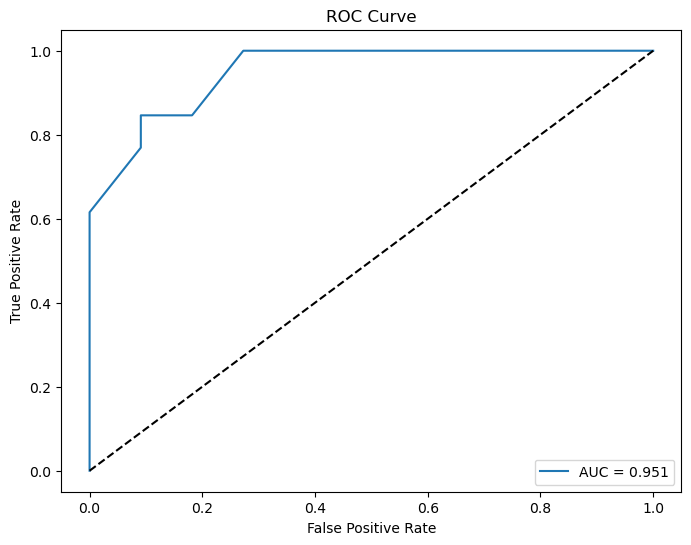

In [8]:
# Generate Predictions
y_pred = grid_search.predict(X_test)
y_prob = grid_search.predict_proba(X_test)[:,1]  # Probability estimates of the positive class

# Compute Performance Metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)  # Note: use predicted probabilities for AUC

# Print Metrics
print(f'Accuracy: {acc:.3f}')
print(f'Precision: {prec:.3f}')
print(f'Recall: {rec:.3f}')
print(f'F1 Score: {f1:.3f}')
print(f'AUC: {auc:.3f}')

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


## 8. Visualization and Discussion

There are multiple ways we can measure how accurate the model predicts:

Accuracy is the ration of true positives and true negatives to all the sample. In other words, we measure what percentage of the set we classified correctly. Accuracy of  0.875 indicates that we classified most of the items correctly. 

Precision is ratio of correctly prediced positive classes to all items predicted positive, in this case equal to  0.812. This means there are a few False positives that the model classified. Sometimes, accuracy can be tricky metric. But, in this dataset, the number of food and non-food items are approximately the same, without one dominating over the other. Therefore, accuracy can give a useful information in this problem. 

Recall is ratio of correctly predicted positive classes to all items that are actually positive, which is equal to 1. This indicates that the model correctly classified all food items as food items. 

On the other hand, f1 score takes account for noth precision and recall. The formula look like:

F1 = 2*precision*recall/(precision+recall). This metric ensures that the balance between the precision and recall is held. In this case, we have f1 = 0.897, which indicates that it has a good balance between the two. 

AUC(Area under the curve) is the area underneath the entire ROC curve. AUC = 0.5 would indicate the model is random so anything below the diagonal line is considered useless. This metrix measures tries to maximize the try positive, and minimize false positive. In our example, we see that AUC = 0.951, which indicate that it is pretty good at classifiying the classes. 

This is not a Cost-Sensitive problem compared to cancer detection, so these metrics indicate that the model does a good job (at least on this test set).

For simpler vizualization, we can check the confusion matrix below. Here we can see that, indeed, the metrics above described the model's performance accurately. 

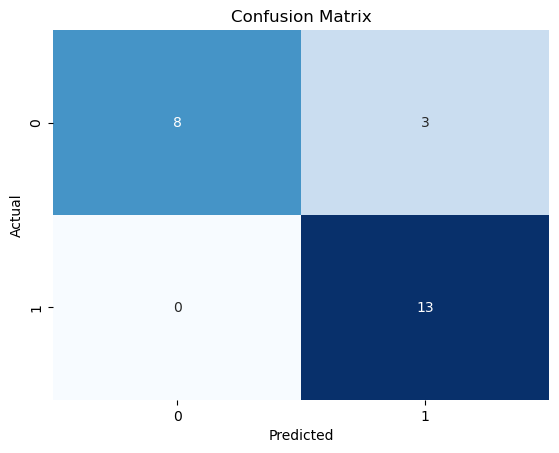

In [9]:
#plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In the confusion matrix, we see that some non-food items are classified as food. Let's see what items are classified correctly and incorrectly.

In [10]:

# DataFrame to easily visualize and analyze results
results_df = pd.DataFrame({
    'Description': X_test,  
    'Actual': y_test, 
    'Predicted': y_pred 
})

#Correctly classified transactions
correct = results_df[results_df['Actual'] == results_df['Predicted']]

#Incorrectly classified transactions
incorrect = results_df[results_df['Actual'] != results_df['Predicted']]

#print
print("Some correctly classified transactions:")
print(correct.head())
print("\nSome incorrectly classified transactions:")
print(incorrect.head())

Some correctly classified transactions:
                                 Description  Actual  Predicted
56         h mart - chica  mobile purchase         1          1
26      mcdonald's f39148  mobile purchase         1          1
95      smashburger #1733  mobile purchase         1          1
31        target 00032078  mobile purchase         1          1
42  starbucks store 19549  mobile purchase         1          1

Some incorrectly classified transactions:
                                   Description  Actual  Predicted
90      frontier ai mec35d  purchase denver co       0          1
98           walgreens stor  mobile purchase         0          1
101  amc 0133 river east 21  mobile purchase         0          1


Above we see 3 items are classified incorrectly. I can explain that the reason they are classified incorrectly is because there is only 1 entries for each of these places. Therefore, it is predictable that the model will classify them incorrectly, since there is no other entry in the training set about Walgreens or AMC. 

## 9. Summary
Overall, the model does a pretty good job. It could be because once the model starts to figure out which words are related to food and non food items, it is pretty straight-forward. There are some noise in the descriptions such as words like mobile purchase, and transaction number. 
To further improve the model, I need more data so the mistakes like we saw above with Walgreens and AMC would not occur. 

I am not completely sure what the transaction codes refer to but I had a hope that the model could find patterns I cannot comprehend. Google described that these numbers help banks classify the transaction types. Therefore, there is a possibility for the model to catch up on meanings of some numbers. 

In [11]:
# Access the LogisticRegression model using the key 'clf'
log_reg = grid_search.best_estimator_.named_steps['clf']

# Retrieve coefficients
coefficients = log_reg.coef_[0]
features = vectorizer.get_feature_names_out()

# Create a DataFrame for easier manipulation
import pandas as pd
df = pd.DataFrame({'Feature': features, 'Coefficient': coefficients})

# Sort DataFrame by coefficient value to see words most correlated with each class
sorted_df = df.sort_values(by='Coefficient', ascending=False)

# Display top words correlated to food items (positive coefficients)
print("Top words correlated to food items:")
print(sorted_df.head(10))

# Display top words correlated to non-food items (negative coefficients)
print("\nTop words correlated to non-food items:")
print(sorted_df.tail(10))


Top words correlated to food items:
        Feature  Coefficient
131      mobile     1.344632
182      target     0.717733
198         tst     0.650019
0      00032078     0.639210
157       ramen     0.531303
128    mcdonald     0.470030
167          sq     0.454214
92        feder     0.442179
61      capital     0.442179
162  schaumburg     0.378415

Top words correlated to non-food items:
      Feature  Coefficient
64   chinguun    -0.526345
126      lyft    -0.560735
66        com    -0.585412
51       belo    -0.609822
22         42    -0.609822
46       amzn    -0.651562
57         ca    -0.701451
60        cap    -0.714055
93    federal    -0.714055
202    ventra    -2.562085


Above, I can see the top words correlated to both classes. We can see that many of the words are correctly identified as indicator of the relevant classes (e.g., Food: "target", "ramen"; Non-Food: "federal", "amzn"). 
We can also see some items that are not very indicative of each class. This indicates that the model has picked up some "noise" from the dataset. Interestingly, we can also see some numbers. But we will need more data to make sure what these numbers indicate to banks. 


## 10. Reference
The dataset can be found: 

https://shorturl.at/txESW
This dataset contains only my information, and was used for my learning purpose. 

Works Cited Golovin, Aleksandr. “Neural Networks Decoded: How Logistic Regression Is the Hidden First Step.” Medium, Medium, 16 Sept. 2023, medium.com/@axegggl/neural-networks-decoded-how-logistic-regression-is-the-hidden-first-step-495f4a0b5fd. Accessed 15 Oct. 2023.Wilber, Jared. “ROC and AUC.” MLU-Explain, 2023, mlu-explain.github.io/roc-auc/. Accessed 15 Oct. 2023.

I acknowledge the use of ChatGPT to assist with my questions and tasks.

